# GER40 Market Data Curation
Analysis of 1-minute GER40 market data to identify gaps, statistics, and trading schedules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Load Data

In [2]:
df = pd.read_csv('../raw-data/GER40_M1_20230101_20251110.csv')
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').reset_index(drop=True)
print(f"Total records: {len(df):,}")
print(f"Date range: {df['Time'].min()} to {df['Time'].max()}")
df.head()

Total records: 863,365
Date range: 2023-01-02 00:18:00+00:00 to 2025-11-10 20:59:00+00:00


,Time,OpenBid,OpenAsk,HighBid,HighAsk,LowBid,LowAsk,CloseBid,CloseAsk
0,2023-01-02 00:18:00+00:00,13879.11,13895.61,13880.11,13896.61,13879.11,13895.61,13880.11,13896.61
1,2023-01-02 00:19:00+00:00,13881.11,13896.61,13882.11,13896.61,13878.11,13894.61,13878.11,13895.61
2,2023-01-02 00:20:00+00:00,13878.11,13894.61,13878.11,13894.61,13878.11,13894.61,13878.11,13894.61
3,2023-01-02 00:21:00+00:00,13879.11,13894.61,13888.11,13894.61,13878.11,13893.61,13880.11,13893.61
4,2023-01-02 00:22:00+00:00,13880.11,13896.61,13881.11,13896.61,13880.11,13893.61,13881.11,13894.61


## Basic Statistics

In [3]:
print("Data shape:", df.shape)
print("\nColumn types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nPrice statistics (CloseBid):")
print(df['CloseBid'].describe())

Data shape: (863365, 9)

Column types:
Time        datetime64[ns, UTC]
OpenBid                 float64
OpenAsk                 float64
HighBid                 float64
HighAsk                 float64
LowBid                  float64
LowAsk                  float64
CloseBid                float64
CloseAsk                float64
dtype: object

Missing values:
Time        0
OpenBid     0
OpenAsk     0
HighBid     0
HighAsk     0
LowBid      0
LowAsk      0
CloseBid    0
CloseAsk    0
dtype: int64

Price statistics (CloseBid):
count    863365.000000
mean      18859.644583
std        3166.279783
min       13846.110000
25%       15937.300000
50%       18293.660000
75%       21779.910000
max       24770.520000
Name: CloseBid, dtype: float64


## Time Gap Analysis

In [4]:
df['time_diff'] = df['Time'].diff()
print("Time differences between consecutive records:")
print(df['time_diff'].value_counts().head(20))
print(f"\nExpected 1-minute intervals: {(df['time_diff'] == timedelta(minutes=1)).sum():,}")
print(f"Gaps > 1 minute: {(df['time_diff'] > timedelta(minutes=1)).sum():,}")

Time differences between consecutive records:
time_diff
0 days 00:01:00    850306
0 days 00:02:00      9454
0 days 00:03:00      1862
0 days 00:04:00       559
0 days 04:16:00       347
0 days 00:05:00       216
0 days 03:16:00       212
0 days 00:06:00       107
2 days 04:16:00        87
0 days 00:07:00        55
2 days 03:16:00        55
0 days 00:08:00        27
0 days 00:09:00        23
0 days 00:11:00         8
0 days 03:17:00         8
0 days 00:12:00         5
0 days 04:17:00         5
0 days 00:10:00         4
3 days 03:16:00         2
4 days 03:16:00         2
Name: count, dtype: int64

Expected 1-minute intervals: 850,306
Gaps > 1 minute: 13,058


## Missing Data Periods

In [5]:
gaps = df[df['time_diff'] > timedelta(minutes=1)].copy()
gaps['gap_minutes'] = gaps['time_diff'].dt.total_seconds() / 60
print(f"Total gaps: {len(gaps)}")
print("\nLargest gaps:")
print(gaps[['Time', 'gap_minutes']].sort_values('gap_minutes', ascending=False).head(20))

Total gaps: 13058

Largest gaps:
                            Time  gap_minutes
83801  2023-04-11 00:15:00+00:00       6016.0
694433 2025-04-22 00:15:00+00:00       6016.0
299430 2023-12-27 00:15:00+00:00       5956.0
379225 2024-04-02 00:15:00+00:00       5956.0
100153 2023-05-02 00:15:00+00:00       4576.0
303040 2024-01-02 00:15:00+00:00       4516.0
600543 2024-12-27 00:15:00+00:00       4516.0
684189 2025-04-07 00:24:00+00:00       3145.0
826165 2025-09-29 00:15:00+00:00       3136.0
405825 2024-05-06 00:15:00+00:00       3136.0
192121 2023-08-21 00:15:00+00:00       3136.0
186206 2023-08-14 00:15:00+00:00       3136.0
756528 2025-07-07 00:15:00+00:00       3136.0
762397 2025-07-14 00:15:00+00:00       3136.0
744917 2025-06-23 00:15:00+00:00       3136.0
198009 2023-08-28 00:15:00+00:00       3136.0
843840 2025-10-20 00:15:00+00:00       3136.0
849735 2025-10-27 00:15:00+00:00       3136.0
750715 2025-06-30 00:15:00+00:00       3136.0
401226 2024-04-29 00:15:00+00:00       3136.0


## Daily Trading Schedule Analysis

In [6]:
df['date'] = df['Time'].dt.date
df['hour'] = df['Time'].dt.hour
df['minute'] = df['Time'].dt.minute
df['day_of_week'] = df['Time'].dt.day_name()
daily_counts = df.groupby('date').size()
print("Records per day statistics:")
print(daily_counts.describe())
print("\nSample of days with record counts:")
print(daily_counts.head(20))

Records per day statistics:
count     729.000000
mean     1184.314129
std        35.571532
min       989.000000
25%      1168.000000
50%      1180.000000
75%      1216.000000
max      1245.000000
dtype: float64

Sample of days with record counts:
date
2023-01-02     989
2023-01-03    1233
2023-01-04    1231
2023-01-05    1236
2023-01-06    1235
2023-01-09    1236
2023-01-10    1236
2023-01-11    1197
2023-01-12    1181
2023-01-13    1228
2023-01-16    1173
2023-01-17    1233
2023-01-18    1232
2023-01-19    1229
2023-01-20    1213
2023-01-23    1179
2023-01-24    1198
2023-01-25    1214
2023-01-26    1232
2023-01-27    1228
dtype: int64


## Day of Week Analysis

Records by day of week:
day_of_week
Thursday     174338
Friday       173568
Wednesday    172830
Tuesday      172804
Monday       169825
Name: count, dtype: int64


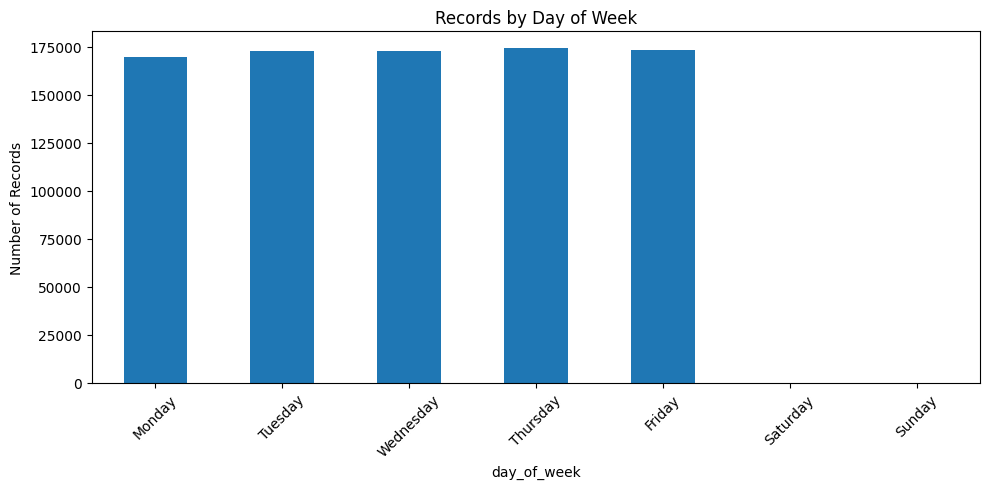

In [7]:
dow_counts = df['day_of_week'].value_counts()
print("Records by day of week:")
print(dow_counts)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = dow_counts.reindex(days_order)
dow_counts.plot(kind='bar', title='Records by Day of Week', figsize=(10, 5))
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Hourly Trading Patterns

Records by hour of day:
hour
0     31254
1     42252
2     41149
3     40183
4     39285
5     42333
6     43271
7     43704
8     43716
9     43696
10    43728
11    43731
12    43726
13    43730
14    43731
15    43732
16    43697
17    43426
18    43141
19    43240
20    16640
Name: count, dtype: int64


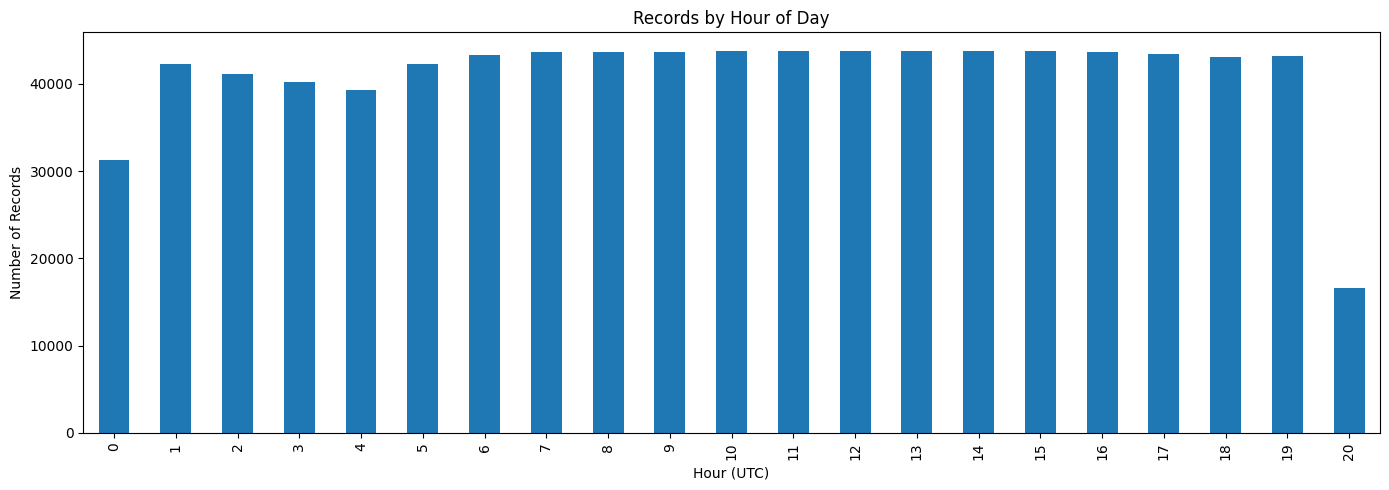

In [8]:
hourly_counts = df['hour'].value_counts().sort_index()
print("Records by hour of day:")
print(hourly_counts)
hourly_counts.plot(kind='bar', title='Records by Hour of Day', figsize=(14, 5))
plt.xlabel('Hour (UTC)')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

## First and Last Trading Times Each Day

In [9]:
daily_schedule = df.groupby('date')['Time'].agg(['min', 'max'])
daily_schedule['first_time'] = daily_schedule['min'].dt.time
daily_schedule['last_time'] = daily_schedule['max'].dt.time
daily_schedule['trading_hours'] = (daily_schedule['max'] - daily_schedule['min']).dt.total_seconds() / 3600
print("Sample daily schedules:")
print(daily_schedule.head(30))
print("\nMost common opening times:")
print(daily_schedule['first_time'].value_counts().head(10))
print("\nMost common closing times:")
print(daily_schedule['last_time'].value_counts().head(10))

Sample daily schedules:
                                 min                       max first_time  \
date                                                                        
2023-01-02 2023-01-02 00:18:00+00:00 2023-01-02 20:59:00+00:00   00:18:00   
2023-01-03 2023-01-03 00:15:00+00:00 2023-01-03 20:59:00+00:00   00:15:00   
2023-01-04 2023-01-04 00:15:00+00:00 2023-01-04 20:59:00+00:00   00:15:00   
2023-01-05 2023-01-05 00:15:00+00:00 2023-01-05 20:59:00+00:00   00:15:00   
2023-01-06 2023-01-06 00:15:00+00:00 2023-01-06 20:59:00+00:00   00:15:00   
2023-01-09 2023-01-09 00:15:00+00:00 2023-01-09 20:59:00+00:00   00:15:00   
2023-01-10 2023-01-10 00:15:00+00:00 2023-01-10 20:59:00+00:00   00:15:00   
2023-01-11 2023-01-11 00:15:00+00:00 2023-01-11 20:59:00+00:00   00:15:00   
2023-01-12 2023-01-12 00:15:00+00:00 2023-01-12 20:59:00+00:00   00:15:00   
2023-01-13 2023-01-13 00:15:00+00:00 2023-01-13 20:59:00+00:00   00:15:00   
2023-01-16 2023-01-16 00:15:00+00:00 2023-01-16 20:5

## Price Range and Volatility

Spread statistics:
count    863365.000000
mean          2.817718
std           1.692768
min           1.000000
25%           1.500000
50%           2.500000
75%           3.500000
max          17.500000
Name: spread, dtype: float64

Returns statistics:
count    8.633640e+05
mean     6.749412e-07
std      2.752253e-04
min     -3.004450e-02
25%     -1.032540e-04
50%      0.000000e+00
75%      1.065402e-04
max      2.155665e-02
Name: returns, dtype: float64


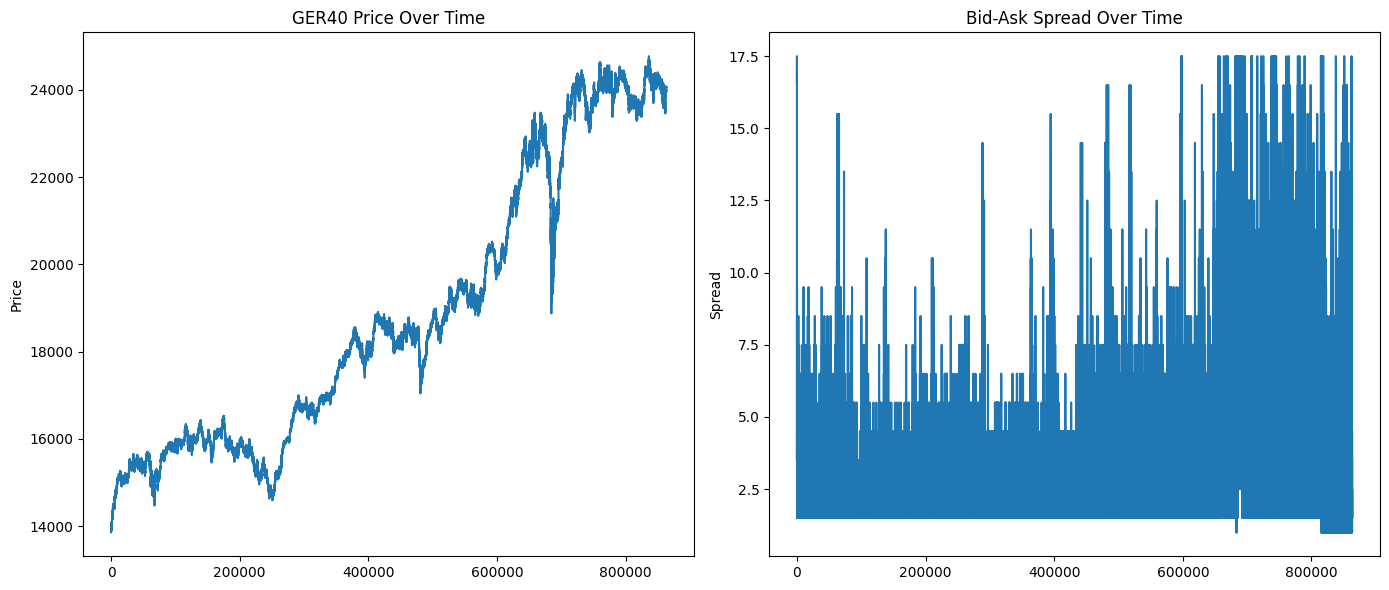

In [10]:
df['mid_price'] = (df['CloseBid'] + df['CloseAsk']) / 2
df['spread'] = df['CloseAsk'] - df['CloseBid']
df['returns'] = df['mid_price'].pct_change()
print("Spread statistics:")
print(df['spread'].describe())
print("\nReturns statistics:")
print(df['returns'].describe())
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
df['mid_price'].plot(title='GER40 Price Over Time')
plt.ylabel('Price')
plt.subplot(1, 2, 2)
df['spread'].plot(title='Bid-Ask Spread Over Time')
plt.ylabel('Spread')
plt.tight_layout()
plt.show()

## Data Completeness Check

In [12]:
start_time = df['Time'].min()
end_time = df['Time'].max()
expected_minutes = int((end_time - start_time).total_seconds() / 60) + 1
actual_records = len(df)
completeness = (actual_records / expected_minutes) * 100
print(f"Expected minutes (if continuous): {expected_minutes:,}")
print(f"Actual records: {actual_records:,}")
print(f"Data completeness: {completeness:.2f}%")
print(f"Missing records: {expected_minutes - actual_records:,}")

Expected minutes (if continuous): 1,503,162
Actual records: 863,365
Data completeness: 57.44%
Missing records: 639,797


## Summary Report

In [13]:
print("="*60)
print("GER40 DATA CURATION SUMMARY")
print("="*60)
print(f"\nData Period: {df['Time'].min()} to {df['Time'].max()}")
print(f"Total Records: {len(df):,}")
print(f"Data Completeness: {completeness:.2f}%")
print(f"\nTrading Days by Day of Week:")
trading_days = df.groupby(['date', 'day_of_week']).size().reset_index()[['date', 'day_of_week']]
print(trading_days['day_of_week'].value_counts().reindex(days_order))
print(f"\nTypical Trading Hours (UTC):")
print(f"  Most common open: {daily_schedule['first_time'].mode()[0]}")
print(f"  Most common close: {daily_schedule['last_time'].mode()[0]}")
print(f"\nPrice Range: {df['CloseBid'].min():.2f} - {df['CloseBid'].max():.2f}")
print(f"Average Spread: {df['spread'].mean():.2f}")
print(f"\nData Quality Issues:")
print(f"  Missing values: {df.isnull().sum().sum()}")
print(f"  Time gaps > 1 min: {(df['time_diff'] > timedelta(minutes=1)).sum():,}")
print("="*60)

GER40 DATA CURATION SUMMARY

Data Period: 2023-01-02 00:18:00+00:00 to 2025-11-10 20:59:00+00:00
Total Records: 863,365
Data Completeness: 57.44%

Trading Days by Day of Week:
day_of_week
Monday       144.0
Tuesday      146.0
Wednesday    146.0
Thursday     147.0
Friday       146.0
Saturday       NaN
Sunday         NaN
Name: count, dtype: float64

Typical Trading Hours (UTC):
  Most common open: 00:15:00
  Most common close: 19:59:00

Price Range: 13846.11 - 24770.52
Average Spread: 2.82

Data Quality Issues:
  Missing values: 2
  Time gaps > 1 min: 13,058
